In [1]:
# Defaults
REGION = 'fortportal'
POP = 'grid_population'
UTM = 32636
CLUSTER_COUNT = 10

In [2]:
# Parameters
REGION = "fortportal"
UTM = 32636
POP = "grid_population"
PIPELINE = "cluster"


In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn import cluster
from pathlib import Path
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation


warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
CWD = Path('.')
DATA = Path('data')

INTER  = DATA/'inter'
INPUT  = DATA/'input'
OUTPUT = DATA/'output'

In [5]:
!ls {OUTPUT} | grep {REGION}

fortportal_agglomerative.geojson
fortportal_grids_output_4326.geojson
fortportal_kmeans.geojson
fortportal_moran.geojson


In [6]:
grids_gdf = gpd.read_file(f'{OUTPUT}/{REGION}_grids_output_{4326}.geojson').to_crs(epsg=UTM)

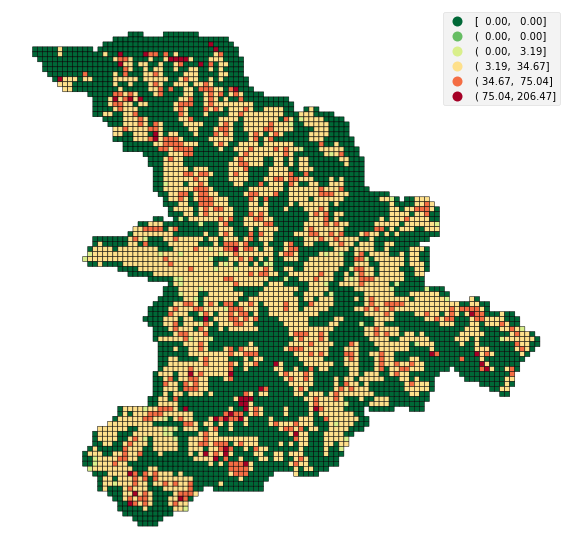

In [7]:
grids_gdf.plot(figsize=(10,10), cmap='RdYlGn_r', edgecolor='black', alpha=1, column=POP, scheme='percentiles', legend=True)
plt.gca().set_axis_off()

In [8]:
grids_gdf.head()

,idx,grid_building_area,grid_building_count,tile_idx,tile_population,tile_width,tile_height,tile_building_count,tile_building_area,grid_population,geometry
0,0,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193062.306 76631.449, 193155.133 766..."
1,1,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193155.133 76631.395, 193247.960 766..."
2,2,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193247.960 76631.341, 193340.787 766..."
3,3,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193340.787 76631.287, 193433.613 766..."
4,4,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193433.613 76631.233, 193526.440 766..."


In [9]:
def make_copy(gdf): return gdf.copy()

In [10]:
def moran_cluster(gdf):
    w = weights.Queen.from_dataframe(gdf, idVariable='idx')
    gdf = gdf[~gdf.idx.isin(w.islands)]
    w = weights.Queen.from_dataframe(gdf, idVariable='idx')
    w.tranform = 'R'
    gdf[f'w_{POP}'] = weights.lag_spatial(w, gdf[POP])
    # MI = esda.Moran(gdf[f'w_{POP}'], w)
    LISA = esda.Moran_Local(gdf[f'w_{POP}'], w) 
    gdf['significance'] = LISA.p_sim < 0.05
    gdf['_quad'] = LISA.q
    gdf['quad'] = gdf['_quad'].replace({
        1: 'HH',
        2: 'LH',
        3: 'LL',
        4: 'HL'
    })
    
    moran_dissolved_gdf = (gdf[['geometry', 'grid_population', 'grid_building_count', 'grid_building_area', 'quad']]
            .dissolve(by='quad', aggfunc='mean')
            .reset_index())
    
    return gdf, LISA, moran_dissolved_gdf

# Cluster regions based on Moran Index

In [11]:
moran_gdf, LISA, moran_dissolved_gdf = grids_gdf.pipe(make_copy).pipe(moran_cluster)

In [12]:
moran_gdf.head()

,idx,grid_building_area,grid_building_count,tile_idx,tile_population,tile_width,tile_height,tile_building_count,tile_building_area,grid_population,geometry,w_grid_population,significance,_quad,quad
0,0,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193062.306 76631.449, 193155.133 766...",0.000000,True,3,LL
1,1,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193155.133 76631.395, 193247.960 766...",0.000000,True,3,LL
2,2,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193247.960 76631.341, 193340.787 766...",0.000000,True,3,LL
3,3,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193340.787 76631.287, 193433.613 766...",0.000000,True,3,LL
4,4,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193433.613 76631.233, 193526.440 766...",33.315432,True,3,LL


In [13]:
moran_gdf['quad'].value_counts()

LL    2470
HH    1951
LH     296
HL     217
Name: quad, dtype: int64

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

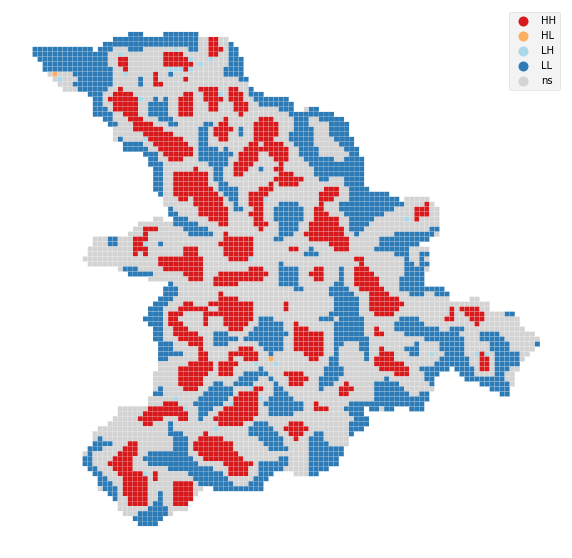

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
lisa_cluster(LISA, moran_gdf, ax=ax)

(<Figure size 1440x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

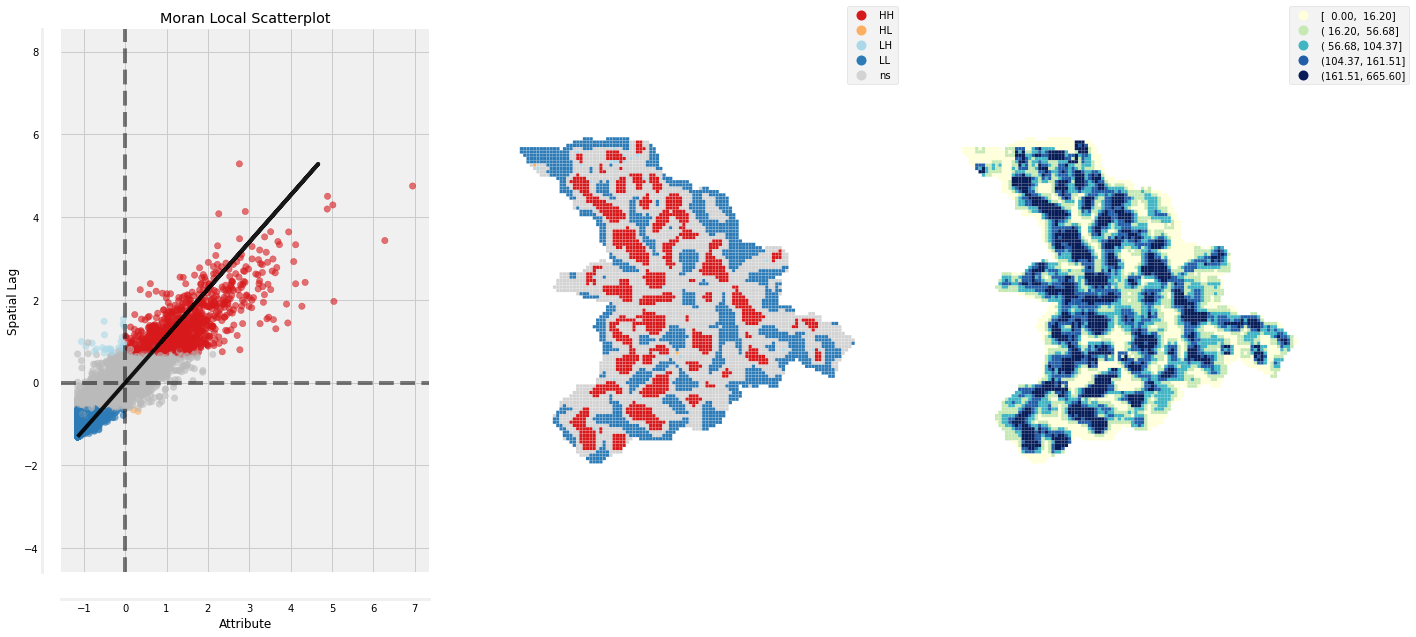

In [15]:
plot_local_autocorrelation(LISA, moran_gdf, f'w_{POP}', figsize=(20, 10))

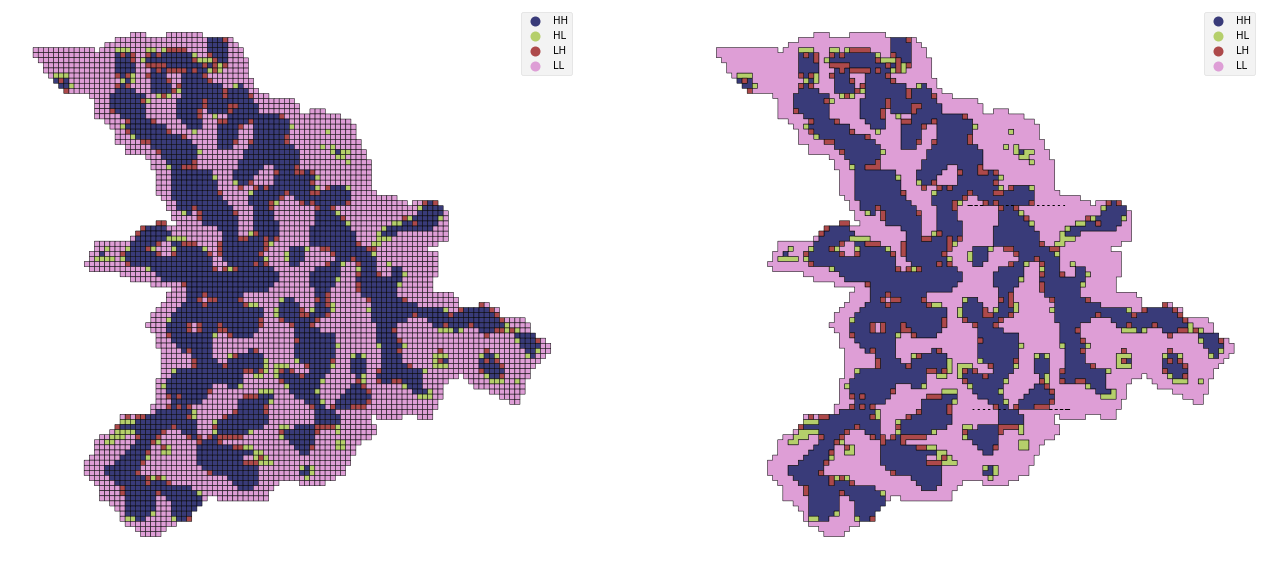

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 20))

moran_gdf.plot(ax=ax1, cmap='tab20b', edgecolor='black', categorical=True, column='quad', figsize=(20, 20), legend=True)
moran_dissolved_gdf.plot(ax=ax2, cmap='tab20b', edgecolor='black', categorical=True, column='quad', figsize=(20, 20), legend=True)
ax1.set_axis_off()
ax2.set_axis_off()

# Cluster regions based on K-Means

In [17]:
def kmeans_cluster(gdf, k=CLUSTER_COUNT):
    k_score = cluster.KMeans(n_clusters=k)
    gdf['k_score'] = k_score.fit(gdf[['grid_population']]).labels_
    kmeans_dissolved_gdf = (gdf[['geometry', 'grid_population', 'grid_building_count', 'grid_building_area', 'k_score']]
                    .dissolve(by='k_score', aggfunc='mean')
                    .reset_index())
    
    return gdf, kmeans_dissolved_gdf

In [18]:
kmeans_gdf, kmeans_dissolved_gdf = grids_gdf.pipe(make_copy).pipe(kmeans_cluster)

In [19]:
kmeans_gdf.head()

,idx,grid_building_area,grid_building_count,tile_idx,tile_population,tile_width,tile_height,tile_building_count,tile_building_area,grid_population,geometry,k_score
0,0,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193062.306 76631.449, 193155.133 766...",0
1,1,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193155.133 76631.395, 193247.960 766...",0
2,2,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193247.960 76631.341, 193340.787 766...",0
3,3,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193340.787 76631.287, 193433.613 766...",0
4,4,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193433.613 76631.233, 193526.440 766...",0


In [20]:
kmeans_dissolved_gdf

,k_score,geometry,grid_population,grid_building_count,grid_building_area
0,0,"MULTIPOLYGON (((197327.974 68514.230, 197327.9...",0.189365,0.066562,4.407478
1,1,"MULTIPOLYGON (((195099.976 68330.956, 195192.8...",33.314745,6.477124,748.218327
2,2,"MULTIPOLYGON (((195656.908 68146.237, 195749.7...",16.781821,3.954380,432.938176
3,3,"MULTIPOLYGON (((195656.955 68238.458, 195749.7...",74.882346,8.288889,1140.594866
4,4,"MULTIPOLYGON (((194821.414 68238.888, 194914.2...",105.450612,6.000000,1343.553054
5,5,"MULTIPOLYGON (((195935.540 68422.736, 196028.3...",57.411868,8.008850,1073.593912
6,6,"MULTIPOLYGON (((199556.728 70172.841, 199649.5...",8.356833,1.968661,182.400971
7,7,"MULTIPOLYGON (((195564.118 68238.506, 195656.9...",24.768641,5.029748,593.300766
8,8,"MULTIPOLYGON (((196957.439 69989.773, 197050.2...",170.677422,6.400000,1239.729781
9,9,"MULTIPOLYGON (((195842.667 68330.573, 195935.4...",43.652562,7.071429,817.121192


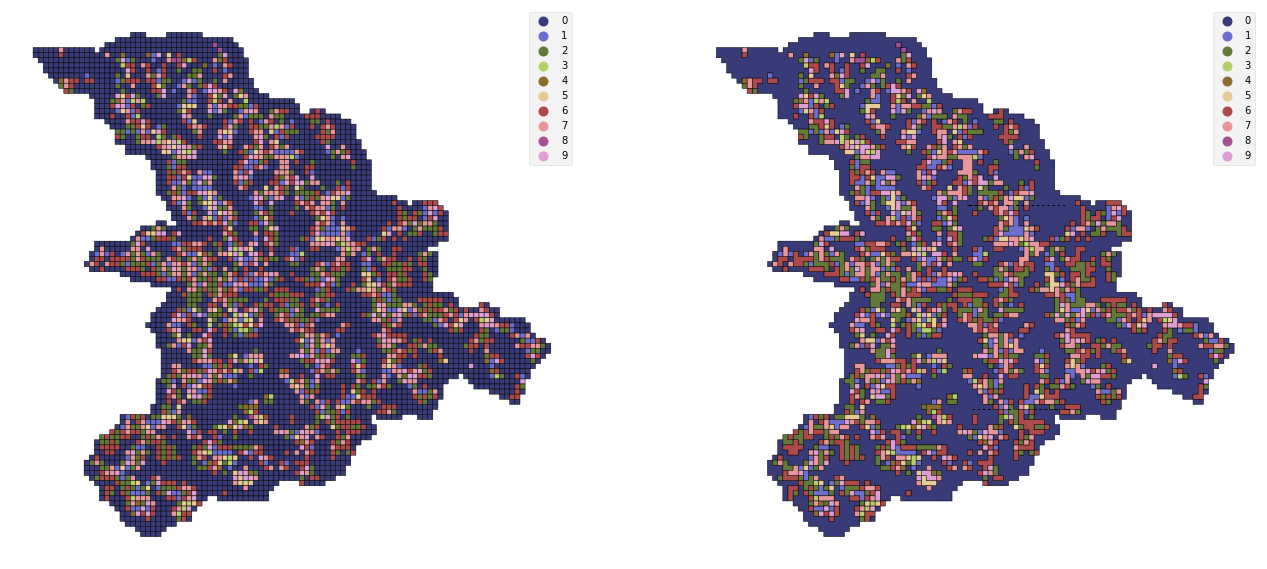

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 20))

kmeans_gdf.plot(ax=ax1, cmap='tab20b', edgecolor='black', column='k_score', categorical=True, figsize=(20, 20), legend=True)
kmeans_dissolved_gdf.plot(ax=ax2, cmap='tab20b', edgecolor='black', column='k_score', categorical=True, figsize=(20, 20), legend=True)
ax1.set_axis_off()
ax2.set_axis_off()

# Cluster regions based on spatial similarity

In [22]:
def agglomerative_cluster(gdf, k=CLUSTER_COUNT*2):
    w = weights.Queen.from_dataframe(gdf)
    a_score = cluster.AgglomerativeClustering(n_clusters=k, connectivity=w.sparse) 
    gdf['a_score'] = a_score.fit(gdf[['grid_population']]).labels_
    agglomerative_dissolved_gdf = (gdf[['geometry', 'grid_population', 'grid_building_count', 'grid_building_area', 'a_score']]
                                       .dissolve(by='a_score', aggfunc='mean')
                                       .reset_index())
    
    return gdf, agglomerative_dissolved_gdf

In [23]:
agglomerative_gdf, agglomerative_dissolved_gdf = agglomerative_cluster(grids_gdf)

In [24]:
agglomerative_gdf.head()

,idx,grid_building_area,grid_building_count,tile_idx,tile_population,tile_width,tile_height,tile_building_count,tile_building_area,grid_population,geometry,a_score
0,0,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193062.306 76631.449, 193155.133 766...",0
1,1,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193155.133 76631.395, 193247.960 766...",0
2,2,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193247.960 76631.341, 193340.787 766...",0
3,3,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193340.787 76631.287, 193433.613 766...",0
4,4,0.0,0,0,25.949927,1,1,2,346.301592,0.0,"POLYGON ((193433.613 76631.233, 193526.440 766...",0


In [25]:
agglomerative_dissolved_gdf

,a_score,geometry,grid_population,grid_building_count,grid_building_area
0,0,"MULTIPOLYGON (((196121.193 68422.640, 196121.1...",2.914429,0.603058,51.318329
1,1,"POLYGON ((195749.745 68146.189, 195749.698 680...",27.959197,4.756303,495.279676
2,2,"MULTIPOLYGON (((195382.076 74970.201, 195382.0...",41.523740,4.326923,387.840390
3,3,"MULTIPOLYGON (((201785.307 71554.877, 201785.2...",22.050689,5.428208,660.118035
4,4,"MULTIPOLYGON (((196957.342 69805.354, 196957.2...",89.819852,4.875000,1399.823795
5,5,"MULTIPOLYGON (((197236.450 71004.041, 197236.4...",38.344878,3.666667,422.693782
6,6,"MULTIPOLYGON (((195475.384 75800.066, 195475.3...",27.287092,2.172414,212.398090
7,7,"POLYGON ((195847.088 76445.403, 195939.913 764...",133.682134,6.250000,1516.320061
8,8,"MULTIPOLYGON (((196678.481 69067.822, 196678.4...",31.750075,4.805687,670.746679
9,9,"MULTIPOLYGON (((197237.394 72756.019, 197330.2...",29.763552,4.561462,593.737392


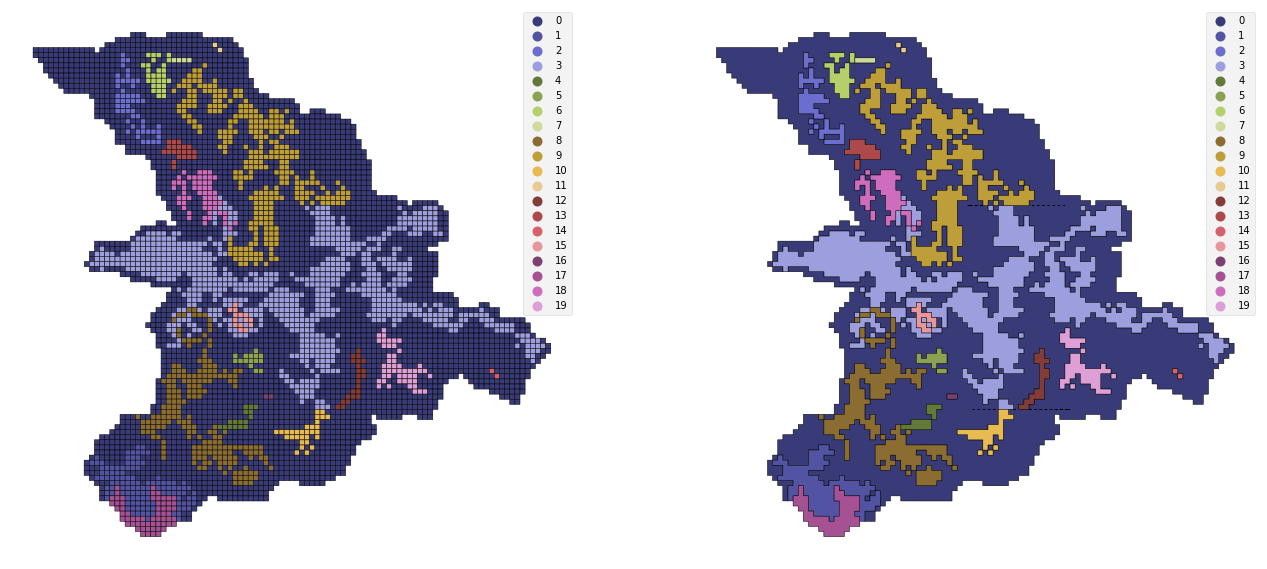

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 20))

agglomerative_gdf.plot(ax=ax1, cmap='tab20b', edgecolor='black', column='a_score', categorical=True, figsize=(20, 20), legend=True)
agglomerative_dissolved_gdf.plot(ax=ax2, cmap='tab20b', edgecolor='black', column='a_score', categorical=True, figsize=(20, 20), legend=True)

ax1.set_axis_off()
ax2.set_axis_off()

### Save the analysed results

In [27]:
moran_dissolved_gdf.to_crs(epsg=4326).to_file(f'{OUTPUT/REGION}_moran.geojson', driver='GeoJSON')
kmeans_dissolved_gdf.to_crs(epsg=4326).to_file(f'{OUTPUT/REGION}_kmeans.geojson', driver='GeoJSON')
agglomerative_dissolved_gdf.to_crs(epsg=4326).to_file(f'{OUTPUT/REGION}_agglomerative.geojson', driver='GeoJSON')